In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


In [21]:
def f1_metric(y_true,y_pred):
        tp = tf.reduce_sum(y_true * tf.round(y_pred), axis=0)
        fp = tf.reduce_sum(tf.round(y_pred) - y_true, axis=0)
        fn = tf.reduce_sum(y_true - tf.round(y_pred), axis=0)

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())

        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        macro_f1 = tf.reduce_mean(f1)
        return macro_f1
def model():
        pre = tf.keras.applications.mobilenet.MobileNet(include_top=False,weights='imagenet',input_shape=(512,512,3))
        pre.trainable=True
        
        inputs = tf.keras.Input(shape=(512,512,3),name='input')
        X = tf.keras.applications.mobilenet.preprocess_input(inputs)
        X = pre(X)
       
        X = tf.keras.layers.GlobalMaxPooling2D()(X)
        outputs = tf.keras.layers.Dense(units=4,activation='softmax')(X)
        model = tf.keras.Model(inputs, outputs)
        model.summary()
        return model

conv_model = model()
conv_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy',f1_metric])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512, 512, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 512, 512, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 512, 512, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 16, 16, 1024)     3228864   
 nal)                                                            
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1024)             0         
 balMaxPooling2D)                                          

In [22]:
from tensorflow.keras.utils import plot_model

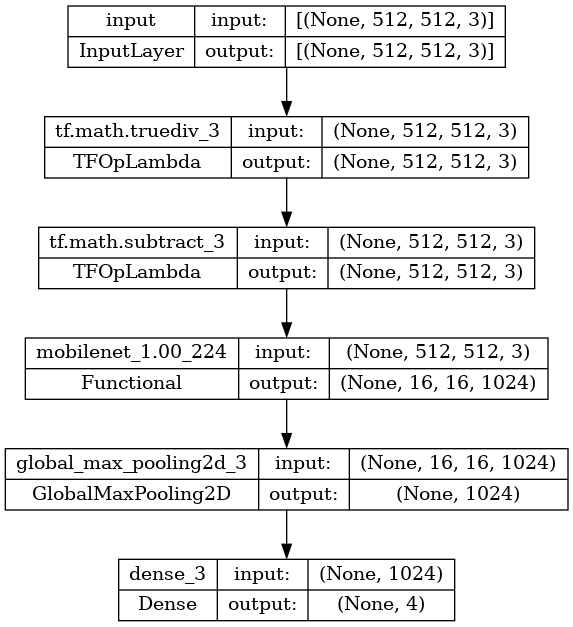

In [23]:
plot_model(conv_model, to_file='model_visualization.png', show_shapes=True)



In [24]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import pydot

In [25]:
tf.keras.utils.plot_model(conv_model, to_file='model_visualization.png', show_shapes=True, 
                          show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

# Set the default graph visualization style
pydot_graph = pydot.graph_from_dot_file('model_visualization.png')
pydot_graph.set('dpi', '96')
pydot_graph.set('rankdir', 'TB')
pydot_graph.write_png('model_visualization.png')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [ ]:
plot_model(conv_model, to_file='model_visualization.dot', show_shapes=True, 
           show_layer_names=True, rankdir='TB', expand_nested=True)

# Convert the DOT file to a PNG image
!pip install pydotplus
import pydotplus
from PIL import Image

graph = pydotplus.graphviz.graph_from_dot_file('model_visualization.dot')
graph.write_png('model_visualization.png')

# Open and display the PNG image
Image.open('model_visualization.png').show()